# Identifying 1st Person/Synthetic Identity Fraud Using Graph Similarity

Within the financial industry, an organization can expect to lose 3-6%, and up to 10%, of its [business to fraudulent activities](http://www.crowe.ie/wp-content/uploads/2019/08/The-Financial-Cost-of-Fraud-2019.pdf).  Fraudulent activities not only impact financial aspects, but victims often have negative views of the company, leading to negative market sentiment.  Overall, these fraudulent activities have a significant impact on a business, in terms of both consumer confidence and bottom-line revenue.  Due to the impact of these illicit activities on the bottom line, companies expend significant time and money to detect and prevent fraud.  

When dealing with fraud, there are two main components to a robust fraud system., fraud detection and fraud prevention.  In fraud detection component of a system, the main goals are to develop a system and methodology that allows for the rapid discovery of fraudulent activities.   This usually involves a posterior evaluation of data, such as transaction, users, credit cards, etc. to determine what patterns or combinations represent actual fraud.  This process usually involves a human-in-the-loop system where automated processes flag likely or potential fraudulent activities, which are then evaluated by an expert in the domain to determine the legitimacy, or ill-legitimacy, of the activities flagged.  The output of this process is a set of known and evolving patterns of fraud that are fed into a fraud prevention system.   Generally, this consists of a real-time system that compares a transaction, or a set of transactions, against the known fraudulent patterns identified by the fraud detection system.  The objective of this fraud prevention system is to reduce and prevent fraudulent activities from occurring in the first place. 


## Challenges of Detecting Fraud

When dealing with fraud, it is often helpful to understand some challenges of finding fraudulent activities when looking into data.  Often this is aided by first understanding the definition and nature of fraud.  While there are many definitions of what fraud is my favorite is:

[Fraud is an uncommon, well-considered, imperceptibly concealed, time-evolving and often carefully organized crime which appears in many types of forms .](https://www.amazon.com/Analytics-Descriptive-Predictive-Network-Techniques/dp/1119133122)


This definition highlights the complex nature of the problems we must address when working on fraud systems.  First, fraud is *uncommon*.  Within any system of recorded transactions, only a small fraction of these transactions consist of fraudulent or illicit activities.  The sparse nature of these illicit activities complicates the nature of identifying these activities.  Second, fraud is *well-considered* and *imperceptibly concealed,* meaning that fraudulent activities are rarely impulsive activities.  Most fraudulent activities, at least at scale, involve multiple parties colluding together to perform actions specifically designed to exploit weaknesses in the system and elude detection.  Finally, fraud is *time-evolving*.  Fraudsters are continuously evolving and adapting their techniques as detection and prevention improve in an endless game of hide and seek.

With these challenges in mind, many fraud detection systems take a multifaceted approach to identifying illicit activities.   In this notebook, we will focus on the use of social networks implicitly found in fraud data to identify fraud rings committing illicit transactions using a guilt-by-association approach.

First-person fraud occurs when a user supplies false information to a company.  Synthetic identity fraud is when users combine real and fake information to create a new synthetic identity.  This is a very common type of fraud that is rampant in most financial institutions.  Solving this type of fraud using a graph relies heavily on using entity resolution type techniques combined with graph analysis to identify similar or connected entities.

## Creating a fraud graph

In this section we'll load the fraud graph and set some visualization options. We'll then use some Gremlin queries to inspect the data model used throughout the solution.

### Load data
The cell below loads the example fraud graph into your Neptune cluster. When you run the cell below a graph for an example Fraud dataset will load., which will take about 5 minutes.

In [ ]:
%seed --model Property_Graph --dataset fraud_graph --run

Now we will install the library we will be using later on in this notebook.  You may need to restart the kernel by going to the menu and selecting the item shown:

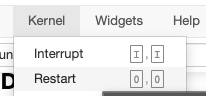
Once you have done this, please reload this browser page and continue.

In [ ]:
pip install awswrangler -q

### Set visualization and configuration options

The cell below configures the visualization to use specific colors and icons for the different parts of the data model.

In [ ]:
%%graph_notebook_vis_options

{
  "groups": {
    "Account": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf2bb",
        "color": "red"
      }
    },
    "Transaction": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf155",
        "color": "green"
      }
    },
    "Merchant": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf290",
        "color": "orange"
      }
    },
    "DateOfBirth": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf1fd",
        "color": "blue"
      }
    },
    "EmailAddress": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf1fa",
        "color": "blue"
      }
    },
    "Address": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf015",
        "color": "blue"
      }
    },
    "IpAddress": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf109",
        "color": "blue"
      }
    },
    "PhoneNumber": {
      "shape": "icon",
      "icon": {
        "face": "FontAwesome",
        "code": "\uf095",
        "color": "blue"
      }
    }
  },
  "edges": {
    "color": {
      "inherit": false
    },
    "smooth": {
      "enabled": true,
      "type": "straightCross"
    },
    "arrows": {
      "to": {
        "enabled": false,
        "type": "arrow"
      }
    },
    "font": {
      "face": "courier new"
    }
  },
  "interaction": {
    "hover": true,
    "hoverConnectedEdges": true,
    "selectConnectedEdges": false
  },
  "physics": {
    "minVelocity": 0.75,
    "barnesHut": {
      "centralGravity": 0.1,
      "gravitationalConstant": -50450,
      "springLength": 95,
      "springConstant": 0.04,
      "damping": 0.09,
      "avoidOverlap": 0.1
    },
    "solver": "barnesHut",
    "enabled": true,
    "adaptiveTimestep": true,
    "stabilization": {
      "enabled": true,
      "iterations": 1
    }
  }
}

### Data model
The fraud graph included in this example models credit card accounts, account holder information, merchants, and the transactions performed when an account holder purchases goods or services from a merchant.

**Account and features**

An Account has a number of features, including physical Address, IpAddress, DateOfBirth of the account holder, EmailAddress, and contact PhoneNumber. An account holder can have multiple email addresses and phone numbers.

In many graph data models these features of the account holder would be modelled as properties of the account. But with fraud detection it's important to be able to link accounts based on shared features, and to find related accounts at query time based on one or more shared features. Hence, our fraud detection application graph data model stores each feature as a separate vertex. Multiple accounts that share the same feature value - the same physical address, for example - are connected to the single vertex representing that feature value. For more details on modelling shared features as vertices, see Relating entities through their attributes at query time.

The following query shows a single account and its associated features. After running the query, click the Graph tab to see a visualization of the results.

### What does my fraud graph look like for an account?

In [ ]:
%%oc -d value -l 20
MATCH p=(n)-[]-()
WHERE id(n)='account-4398046519460' 
RETURN p
LIMIT 10

### What if I only want to look at the account properties, not the transactions?

While the transaction information is very important, but it is often overwhelming, especially on very active accounts.  Often we want to look at only account features, to see how that specific account is connected to features of that account.

In [ ]:
%%oc  -d value -l 20
MATCH p=(n)-[:FEATURE_OF_ACCOUNT]-()
WHERE id(n)='account-4398046519460' 
RETURN p
LIMIT 10

### What else connects to these same features?

After isolating only the account features, we may want to extend our exploration out further to see if we can find other accounts that sharing these features.

In [ ]:
%%oc  -d value -l 20
MATCH p=(n)-[:FEATURE_OF_ACCOUNT*1..2]-()
WHERE id(n)='account-4398046519460' 
RETURN p
LIMIT 10

Well, this is starting to show some interesting information.  As we can see above there a four other accounts that all share the same birthday and one that shares the same phone number.  Having a shared birthday does not seem too suspicious, as there are only so many, but sharing a birthday and sharing a phone number, that seems unlikely.

### Find accounts with shared features?

Let's take a look at what it looks like if we find all accounts that share a feature with another account.

In [ ]:
%%oc  -d value -l 20
MATCH p=(n)-[:FEATURE_OF_ACCOUNT*1..2]-()
RETURN p LIMIT 1000

That is a lot of shared features.  Accounts that share a an anomalous amount of shared features compared to others in a graph are often times a sign that some sort of identity fraud is occurring.  

## Finding Synthetic identities in your graph

When analyzing graph data, a frequent requirement is to infer information/connections from the underlying graph into a different graph form to enable analytics and algorithms to run on it. Many graphs in Neptune contain a rich collection of entities and attributes, such as our transaction graph, that while useful for transactional queries, are not required to perform analytical tasks.

### Inferring a feature graph from your transaction graph

In this example we are going to create a feature graph by inferring that any accounts that are connected by a feature within this  network. We will then use this graph similarity algorithms to decide which accounts are most similar to other accounts

Up until now we have been working with Amazon Neptune directly. For this analysis we are going to leverage an integration between Neptune and Pandas DataFrames, supplied by AWS Data Wrangler, to read and write data from Neptune and the iGraph library to perform network analysis/graph algorithms on top of this data.

Running the cell below will retrieve that needed data from Neptune, in this case an edge list, and load it into a Pandas DataFrame that we will use for later analysis.

In [ ]:
import awswrangler as wr
import pandas as pd
import igraph as ig
import graph_notebook as gn
from graph_notebook.configuration.generate_config import AuthModeEnum

# Get the configuration information for the notebook
config = gn.configuration.get_config.get_config()
iam=True if config.auth_mode==AuthModeEnum.IAM else False

# Retrieve Data from neptune
client = wr.neptune.connect(config.host, config.port, iam_enabled=iam)
query = """MATCH p=(n)-[:FEATURE_OF_ACCOUNT*1..2]-()
with relationships(p) as rels
UNWIND rels as rel
Return id(startNode(rel)) as source, id(endNode(rel)) as target"""
df = wr.neptune.execute_opencypher(client, query)
display(df.head(10))

### Detecting similar nodes

First-person fraud occurs when a user supplies false information to a company.  Synthetic identity fraud is when users combine real and fake information to create a new synthetic identity.  This is a very common type of fraud that is rampant in most financial institutions.  Solving this type of fraud using a graph relies heavily on using entity resolution type techniques combined with graph analysis to identify similar or connected entities. 

In networking analysis/graph algorithms there is an entire class of algorithms, known as similarity algorithms, that evaluate how groups of nodes are connected or partitioned from one another and use this network of connections to identify similar nodes within the graph. While there are a large number of these algorithms the most common similarity algorithms used are Jaccard, Overlap, and k-Nearest Neighbors.

#### Finding graph similarity

Now that we have created our feature graph, we can run a similarity algorithm to find other similar nodes.  Running the cell below will run the Jaccard similarity algorithm on the data, which will compare nodes against all other nodes in the graph to look for nodes that share the same neighbors.  These will then return a score between 0-1 showing how similar two nodes are to each other.

Let's take a look and see what it might look like to find the nodes most similar to `account-4398046519460` that we looked at above.

In [ ]:
# Create a graph from the results returned
g = ig.Graph.TupleList(df.itertuples(index=False), directed=True, weights=False)

vids=[]
account_vs=[]
for idx, v in enumerate(g.vs):
    if v['name'].startswith('account'):
        vids.append(idx)
        account_vs.append(v)
    
sim = g.similarity_jaccard(vertices=vids, loops=False)

for idx, s in enumerate(sim):
    index = None
    max=0
    for i in range(1,len(s)):
        if s[i]<1 and s[i] > max:
            max = s[i]
            index = i
    if index:
        account_vs[index]['similar_node']=account_vs[idx]['name']
        account_vs[index]['similarity_score']=s[index]
        

similar_node={}
for idx, a in enumerate(account_vs):
    if 'similar_node' in a.attributes() and a['similar_node'] and a['name'] == 'account-4398046519460':
        similar_node = {'target_node': a['name'], 'similar_node': a['similar_node'], 'score': a['similarity_score']}
        

print(similar_node)

### Let's look at the similarities for these two accounts

Looking at the data above we see the account that is most similar to our target account.  Let's take a look at what the connections around these two accounts looks like by running the cell below.

In [ ]:
%%oc -d value -l 20

MATCH p=(n)-[:FEATURE_OF_ACCOUNT]-()
WHERE id(n) in ['${similar_node["target_node"]}', '${similar_node["similar_node"]}']
RETURN p
LIMIT 10

These two accounts only seem to share a single common feature and do not look too similar to me.  In addition to just the fact that these two accounts are the most similar we also have a relative score to show how similar they are to one another.  Let's see what the score is for these two accounts.

In [ ]:
similar_node['score']

Well that is not very high, let's see if we can find some more similar accounts to examine.

### Find the most similar accounts

Let's take a look at all the accounts in our feature graph and find the pair that is the most similar to each other.

In [ ]:
max_sim=0
most_sim=None
for idx, a in enumerate(account_vs):
    if 'similarity_score' in a.attributes() and a['similarity_score'] and a['similarity_score']>max_sim:
        max_sim = a['similarity_score']
        most_sim=a
print(f"The two most similar accounts are {most_sim['similar_node']} and {most_sim['name']}")

Now that we know the two most similar accounts, lets take a look at the graph of their connections.

In [ ]:
%%oc -d value -l 20

MATCH p=(n)-[:FEATURE_OF_ACCOUNT]-()
WHERE id(n) in ["${most_sim['name']}", "${most_sim['similar_node']}"]
RETURN p
LIMIT 10

As we can see these nodes share a significant number of common features so it makes sense that they are ranked as highly similar. Now that we have done this analysis we need to save this data back into our original graph to enable investigations by trained fraud analysts.

### Storing calculated edges with similarity values back into the graph

To store our data back into our original graph we can once again use our AWS Data Wrangler integration to save a Pandas DataFrame into Neptune.  To accomplish this we will first construct a DataFrame consisting of the target and source nodes for a `similar_to` edge and then add the similarity score as a property `jaccard_similarity` to that edge.  We then save this DataFrame back to Neptune using the [`to_property_graph()`](https://aws-data-wrangler.readthedocs.io/en/stable/stubs/awswrangler.neptune.to_property_graph.html#awswrangler.neptune.to_property_graph) method. 

In [ ]:
import uuid

# Delete existing 'similar_to' edges
query = """MATCH p=()-[s:similar_to]->() DELETE s"""
df = wr.neptune.execute_opencypher(client, query)

# Create DataFrame for new edges
rows=[]
for idx, a in enumerate(account_vs):    
    if 'similar_node' in a.attributes() and a['similar_node']:
        rows.append({'~id': uuid.uuid4(), '~label': 'similar_to',
            '~from': a['name'],
            '~to': a['similar_node'],
            'jaccard_similarity(single)': a['similarity_score']})
new_df=pd.DataFrame(rows, columns=['~id','~label', '~from', '~to', 'jaccard_similarity(single)'])

# Save new edges
res = wr.neptune.to_property_graph(client, new_df, use_header_cardinality=True, batch_size=100)

## Analyzing the results

A critical and ongoing part of any fraud workflow is to have a mechanism to enable analysts to investigate and prove/disprove that a potentially fraudulent activity exists. 

### Find the most similar accounts to examine first

A common workflow for a skilled fraud analyst is to start by retrieving a list of prioritized accounts to look at based on the similarity between two accounts.  In the query below we will find the top 5 most similar accounts to examine.

In [ ]:
%%oc -de jaccard_similarity -l 20 --store-to similar

MATCH p=(a:Account)-[s:similar_to]->()
WHERE s.jaccard_similarity IS NOT NULL 
RETURN p ORDER BY s.jaccard_similarity DESC LIMIT 5

To make the exploration a little easier let's retrieve the source and target vertex ids.

In [ ]:
source = similar['results'][0]['p'][0]['~id']
target = similar['results'][2]['p'][0]['~id']

### Explore their connections

The ability to visually explore graphs is a powerful tool that helps fraud analysts understand how certain account are connected.  Let's take a look at the account information for these two accoutns and see the graph of the surrounding connections. 

In [ ]:
%%oc -d value -l 20

MATCH p=(a)-[*1..2]-()
WHERE id(a) in ['${source}', "${target}"]
RETURN p

### Mark as Fraud/Not Fraud

Visual inspection, combined with the domain expertise of a fraud analyst, is a critical factor in being able to determine if anomalous patterns in a graph represent actual fraud or legitimate activity.  Expert analysts are capable at looking at the patterns of transactions and connections and the structural connections between items to determine the legitimacy of an account/transaction.  Once they have made this determination they will often flag these accounts/transactions as fraudulent in the graph to aid in future investigations.

Let's mark the account above as fraudulent by setting the `isFraud` property to `True`

In [ ]:
%%oc -d value -l 20
MATCH (a)
WHERE id(a)='${source}'
SET a.isFraud=True
RETURN a

### Find all fraudulent accounts within five hops 

Now that we have completed our investigation of the source account let's take a look at this new account and see if it is connected to any marked fraudulent accounts.

In [ ]:
%%oc -d value -l 20

MATCH p=(a)-[:FEATURE_OF_ACCOUNT|ACCOUNT*1..5]-(b)
WHERE id(a)='${source}'
AND b.isFraud=True
RETURN p LIMIT 1

Wow, that account shares two features with a known fraudster so it looks suspicious.

## Conclusion
Combating fraud is an ongoing challenge for any organization. The more and faster a team can identify fraud the more efficient anti-fraud systems become, preventing significant financial losses. Finding and understanding fraud rings is a problem that requires the ability to query, analyze, and explore the connections between accounts, transactions, and account features. Combining the ability to query a graph with the ability to run network analysis/graph algorithms on top of that data enables us to derive novel insights from this data.